In [225]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

In [226]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [53]:
atmos_forcing_file = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m04d19.nc')

big_lon_atmos = atmos_forcing_file.variables['nav_lon'][:]

big_lon = np.empty_like(big_lon_atmos)
big_lon[:] = big_lon_atmos[:] - 360

big_lat = atmos_forcing_file.variables['nav_lat'][:]





lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          big_lon,big_lat,grid='GEM2.5',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

print(j,i)

117 78


In [54]:
u_wind = atmos_forcing_file.variables['u_wind'][:,j,i]
v_wind = atmos_forcing_file.variables['v_wind'][:,j,i]
timesteps =u_wind.shape[0]

In [82]:
def uv_wind_timeseries_at_point(grid_weather, j, i, datetimes=False):
    """Return the u and v wind components and time counter values
    at a single grid point from a weather forcing dataset.

    :arg grid_weather: Weather forcing dataset, typically from an
                       :file:`ops_yYYYYmMMdDD.nc` file produced by the
                       :py:mod:`nowcast.workers.grid_to_netcdf` worker.
    :type grid_weather: :py:class:`netCDF4.Dataset`

    :arg int j: j-direction (longitude) index of grid point to get wind
                components at.

    :arg int i: i-direction (latitude) index of grid point to get wind
                components at.

    :arg boolean datetimes: Return time counter values as
                            :py:class:`datetime.datetime` objects if
                            :py:obj:`True`, otherwise return them as
                            :py:class:`arrow.Arrow` objects (the default).

    :returns: 2-tuple of 1-dimensional :py:class:`numpy.ndarray` objects,
              The :py:attr:`u` attribute holds the u-direction wind
              component,
              The :py:attr:`v` attribute holds the v-direction wind
              component,
              and the :py:attr:`time` attribute holds the time counter
              values.
    :rtype: :py:class:`collections.namedtuple`
    """
    u_wind = grid_weather.variables['u_wind'][:, j, i]
    v_wind = grid_weather.variables['v_wind'][:, j, i]
    time = timestamp(grid_weather, range(len(u_wind)))
    if datetimes:
        time = np.array([a.datetime for a in time])
    wind_ts = namedtuple('wind_ts', 'u, v, time')

    return wind_ts(u_wind, v_wind, np.array(time))

def timestamp(dataset, tindex, time_var='time_counter'):
    """Return the time stamp of the tindex time_counter value(s) in dataset.

    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg tindex: time_counter variable index.
    :type tindex: int or iterable

    :arg time_var: name of the time variable
    :type time_var: str

    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances
    """
    time_orig = time_origin(dataset, time_var=time_var)
    time_counter = dataset.variables[time_var]
    try:
        iter(tindex)
    except TypeError:
        tindex = [tindex]
    results = []
    for i in tindex:
        try:
            results.append(time_orig + timedelta(seconds=time_counter[i]))
        except IndexError:
            raise IndexError(
                'time_counter variable has no tindex={}'.format(tindex))
    if len(results) > 1:
        return results
    else:

        return results[0]

def time_origin(dataset, time_var='time_counter'):
    """Return the time_var.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset` or :py:class:`xarray.Dataset`

    :arg time_var: name of time variable
    :type time_var: str

    :returns: Value of the time_origin attribute of the time_counter
              variable.
    :rtype: :py:class:`Arrow` instance
    """
    try:
        time_counter = dataset.variables[time_var]
    except KeyError:
        raise KeyError(
            'dataset does not have {time_var} variable'.format(
                time_var=time_var))
    try:
        # netCDF4 dataset
        time_orig = time_counter.time_origin.title()
    except AttributeError:
        try:
            # xarray dataset
            time_orig = time_counter.attrs['time_origin'].title()
        except KeyError:
            raise AttributeError(
                'NetCDF: '
                '{time_var} variable does not have '
                'time_origin attribute'.format(time_var=time_var))
    value = arrow.get(
        time_orig,
        ['YYYY-MMM-DD HH:mm:ss',
         'DD-MMM-YYYY HH:mm:ss',
         'YYYY-MM-DD HH:mm:ss'])

    return value

import numpy

def smooth(x,window_len=24,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s, mode='same')
    
    return y[window_len - 1:-window_len + 1]



In [56]:
from __future__ import division
import glob
import os
import fnmatch

from collections import namedtuple, OrderedDict
from datetime import (
    datetime,
    timedelta,
)
from resource import getrlimit, RLIMIT_NOFILE
import os

import arrow
import netCDF4 as nc
import pandas as pd
import numpy as np

import warnings

from salishsea_tools import hg_commands as hg

vwind_es = np.empty
uwind_es = np.empty
time_es = np.empty

for file in sorted(glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015*.nc')):
    if fnmatch.fnmatch(file, '*_orig.nc') == False:
        if fnmatch.fnmatch(file, '*ops_y2015m12d15.nc') == False:
        
#     if file != 'results/forcing/atmospheric/GEM2.5/operational/ops_y2015m04d03_orig.nc':
            wind_ts_es = uv_wind_timeseries_at_point(nc.Dataset(file), j, i, datetimes=False)
            uwind_es = np.append(uwind_es , wind_ts_es[0])
            vwind_es = np.append(vwind_es, wind_ts_es[1])
            time_es = np.append(time_es, wind_ts_es[2])
    else:
        continue

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


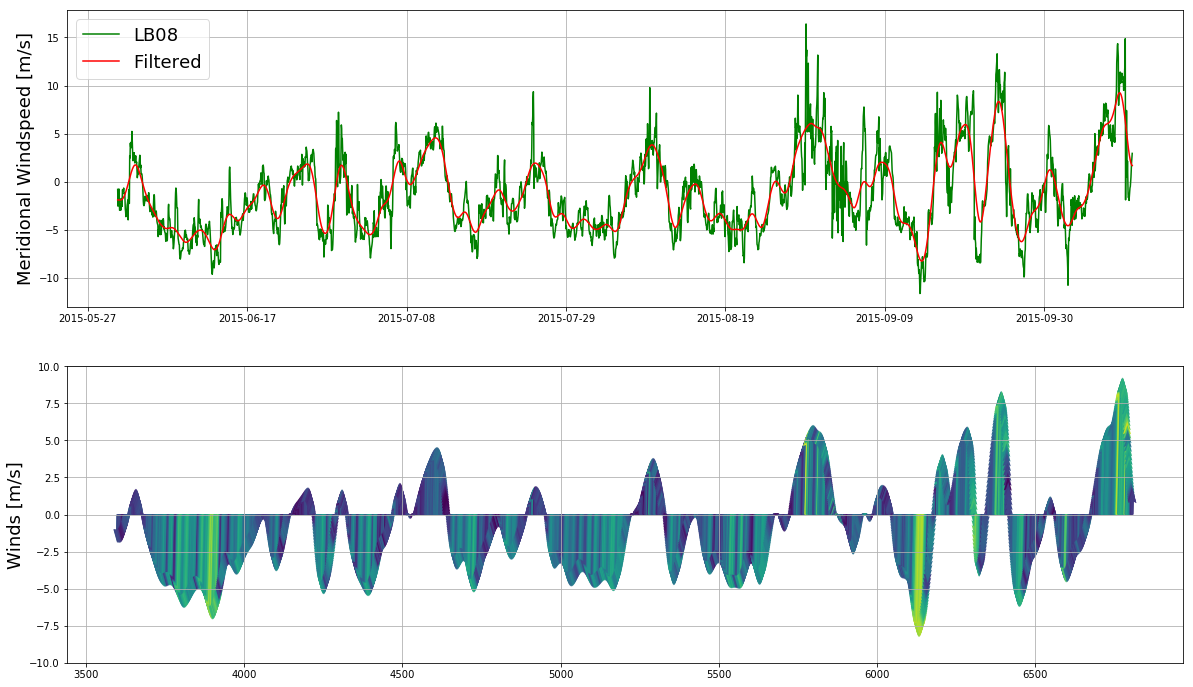

In [99]:
# from salishsea_tools import nc_tools, data_tools, tidetools, visualisations, viz_tools, stormtools, geo_tools
from collections     import OrderedDict
from matplotlib      import pyplot, animation, rcParams, patches
from dateutil        import parser
import datetime
import os
import numpy as np
import xarray


fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,12))

date_time = np.empty_like(time_es)

for i in np.arange(1,time_es.shape[0]):
    date_time[i]  = time_es[i].datetime
    
s_v = vwind_es[3600:6808]   
filt_v = smooth(s_v,72,'hanning')
    

ax1.plot(date_time[3600:6808], vwind_es[3600:6808], 'g-', label = 'LB08')
ax1.plot(date_time[3600:6808], filt_v, 'r-', label = 'Filtered')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax1.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax1.set_ylabel('Meridional Windspeed [m/s]', fontsize =18)
ax1.grid()  


ax2.quiver(np.arange(3600,6808,), 0, np.array(filt_v.astype(np.float64)), np.array(filt_v.astype(np.float64)), wind_abs, angles='xy', scale_units='xy', scale=1)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Winds [m/s]', fontsize =18)
# ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-10,10)
ax2.grid() 

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


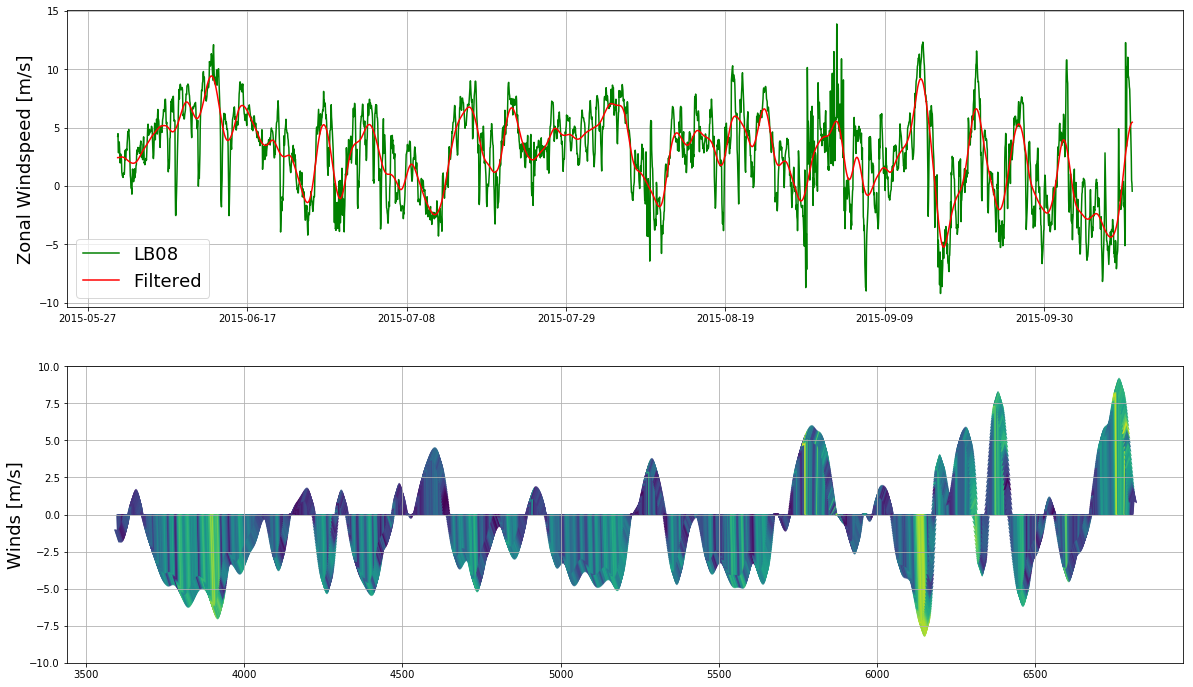

In [100]:
# from salishsea_tools import nc_tools, data_tools, tidetools, visualisations, viz_tools, stormtools, geo_tools
from collections     import OrderedDict
from matplotlib      import pyplot, animation, rcParams, patches
from dateutil        import parser
import datetime
import os
import numpy as np
import xarray


fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,12))

date_time = np.empty_like(time_es)

for i in np.arange(1,time_es.shape[0]):
    date_time[i]  = time_es[i].datetime
    
s_u = uwind_es[3600:6808]   
filt_u = smooth(s_u,72,'hanning')
    

ax1.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
ax1.plot(date_time[3600:6808], filt_u, 'r-', label = 'Filtered')

# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax1.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax1.set_ylabel('Zonal Windspeed [m/s]', fontsize =18)
ax1.grid()    



ax2.quiver(np.arange(3600,6808,), 0, np.array(filt_u.astype(np.float64)), np.array(filt_v.astype(np.float64)), wind_abs, angles='xy', scale_units='xy', scale=1)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Winds [m/s]', fontsize =18)
# ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-10,10)
ax2.grid()   




# plt.figure(figsize=(10,2))
# plt.quiver((time-61), 0, u, v, uv)

In [101]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mesh_mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

mbathy = mesh_mask['mbathy'][0,...]

Z = bathy.variables['Bathymetry'][:]

y_wcvi_slice = np.arange(180,350)
x_wcvi_slice = np.arange(480,650)

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]


short_NEP_iso_jul = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/short_slice_NEP36_jul_along_isopycnal_larger_offshore.nc')

short_spic_iso_jul = short_NEP_iso_jul.variables['spiciness']
short_iso_t = short_NEP_iso_jul.variables['isot']


short_NEP_iso_aug = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/short_NEP36_aug_along_isopycnal_larger_offahore.nc')

short_spic_iso_aug = short_NEP_iso_aug.variables['spiciness']
short_iso_t = short_NEP_iso_aug.variables['isot']


short_NEP_iso_jun = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/short_NEP36_june_along_isopycnal_larger_offshore.nc')

short_spic_iso_jun = short_NEP_iso_jun.variables['spiciness']
short_iso_t = short_NEP_iso_jun.variables['isot']

lon_spic_file = lon[180:350,480:650]
lat_spic_file = lat[180:350,480:650]

lat_LB08 = 48.4217
lon_LB08 = -125.4775

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                                  lon_spic_file,lat_spic_file,tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'\
                                                  GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

print(j,i)

84 119


In [102]:


spic_LB08_jun_26 = short_spic_iso_jun[:,8,j,i]

spic_LB08_jul_26 = short_spic_iso_jul[:,8,j,i]

spic_LB08_aug_26 = short_spic_iso_aug[:,8,j,i]

spic_3_months_LB08_26 = np.concatenate((spic_LB08_jun_26, spic_LB08_jul_26, spic_LB08_aug_26), axis = 0)


spic_LB08_jun_27 = short_spic_iso_jun[:,10,j,i]

spic_LB08_jul_27 = short_spic_iso_jul[:,10,j,i]

spic_LB08_aug_27 = short_spic_iso_aug[:,10,j,i]

spic_3_months_LB08_27 = np.concatenate((spic_LB08_jun_27, spic_LB08_jul_27, spic_LB08_aug_27), axis = 0)


spic_LB08_jun_0 = short_spic_iso_jun[:,0,j,i]

spic_LB08_jul_0 = short_spic_iso_jul[:,0,j,i]

spic_LB08_aug_0 = short_spic_iso_aug[:,0,j,i]

spic_3_months_LB08_0 = np.concatenate((spic_LB08_jun_0, spic_LB08_jul_0, spic_LB08_aug_0), axis = 0)

date1 = '2015-06-01'
date2 = '2015-08-31'
mydates = np.array(pd.date_range(date1, date2))

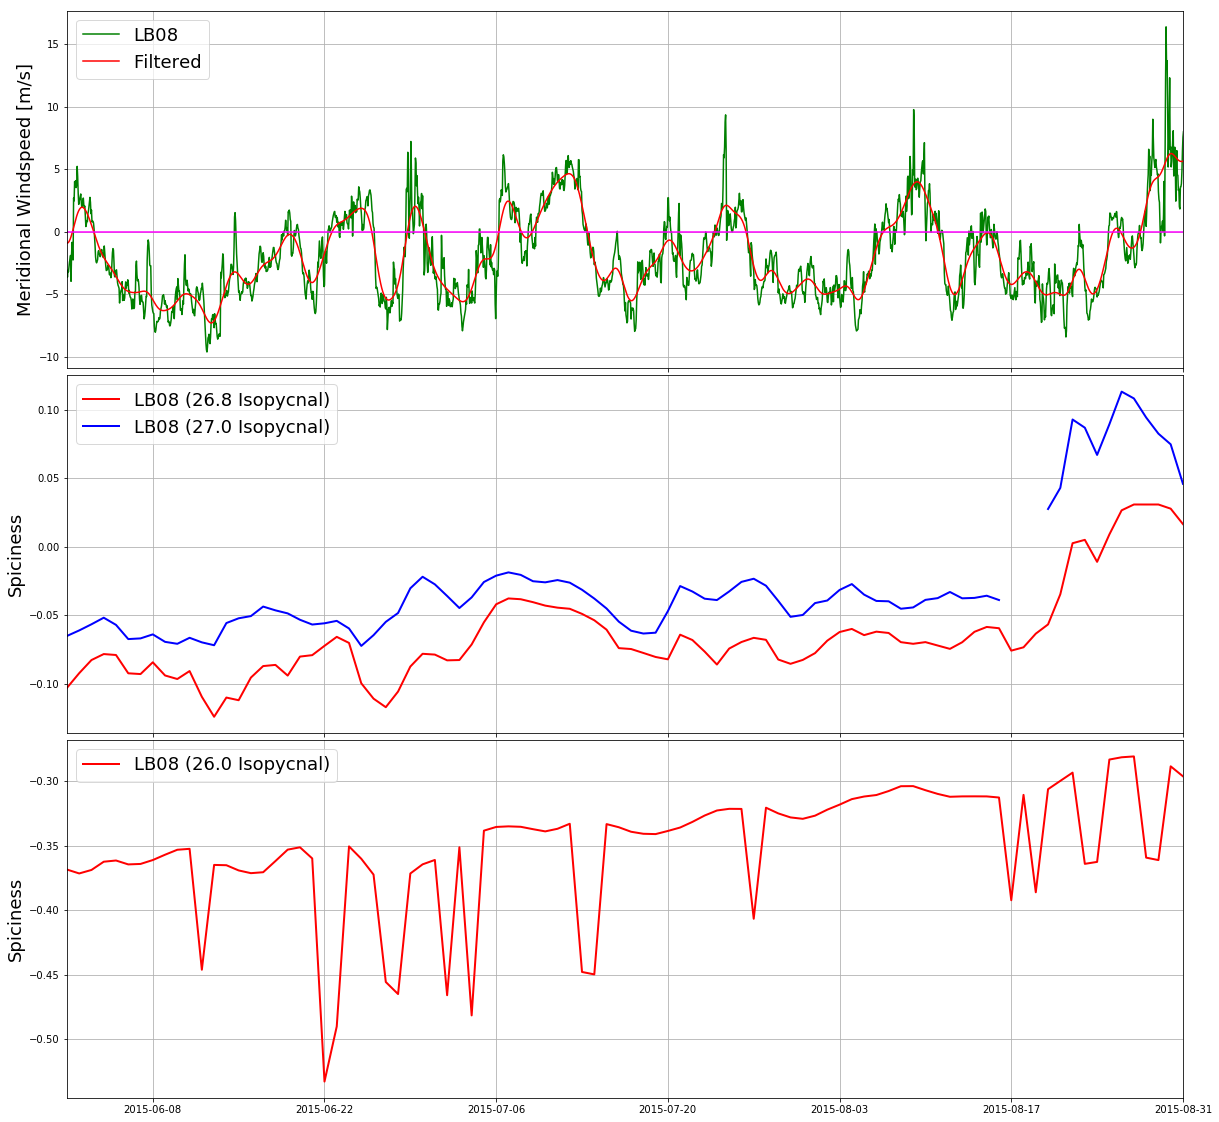

In [214]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
# step = 23
# # time_axis = np.arange(0,u_wind.shape[0],step)
# time_axis = datetime_2015[::step]
# time_axis = timenp[::step]

# time_axis_quiver = np.arange(0,u_wind.shape[0],step)

s_v = vwind_es[3625:5833]   
filt_v = smooth(s_v,72,'blackman')


 
# Make plots
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(20,20), sharex= True)
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
# ax1.plot(time_axis ,vwind_esf[::step], 'r-',linewidth=2)
ax1.plot(date_time[3625:5833], vwind_es[3625:5833], 'g-', label = 'LB08')
ax1.plot(date_time[3625:5833], filt_v, 'r-', label = 'Filtered')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax1.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax1.set_ylabel('Meridional Windspeed [m/s]', fontsize =18)
ax1.axhline(y=0, color='magenta')
ax1.set_xlim(date_time[3625], date_time[5832])
ax1.grid()
# ax1.axes.get_xaxis().set_visible(True)





ax2.plot(mydates , spic_3_months_LB08_26, 'r-',linewidth=2, label = 'LB08 (26.8 Isopycnal)')
ax2.plot(mydates , spic_3_months_LB08_27, 'b-',linewidth=2, label = 'LB08 (27.0 Isopycnal)')
# ax2.quiver(time_axis_quiver, 0, u_wind[::step], v_wind[::step], wind_spd[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Spiciness', fontsize =18)
ax2.set_xlim(mydates[0],mydates[-1])
#ax.set_xticklabels(date_time[3600:6808])
# ax2.set_ylim(-12,10)
ax2.grid() 

ax3.plot(mydates , spic_3_months_LB08_0, 'r-',linewidth=2, label = 'LB08 (26.0 Isopycnal)')
# ax2.plot(mydates , spic_3_months_LB08_27, 'b-',linewidth=2, label = 'LB08 (27.0 Isopycnal)')
# ax2.quiver(time_axis_quiver, 0, u_wind[::step], v_wind[::step], wind_spd[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax3.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax3.set_ylabel('Spiciness', fontsize =18)
ax3.set_xlim(mydates[0],mydates[-1])
#ax.set_xticklabels(date_time[3600:6808])
# ax2.set_ylim(-12,10)
ax3.grid() 

plt.subplots_adjust(hspace=.02)




In [173]:
# np.ma.corrcoef(spic_3_months_LB08_26[:], spic_3_months_LB08_27[:])

# x = np.random.randn(5)
# y = np.sin(x)
df = pd.DataFrame({'spic_26.8':spic_3_months_LB08_26[:], 'spic_27':spic_3_months_LB08_27[:]})

b = df.corr()

print(b)

           spic_26.8   spic_27
spic_26.8   1.000000  0.917133
spic_27     0.917133  1.000000


In [208]:
date_time[5833]

datetime.datetime(2015, 9, 1, 0, 0, tzinfo=tzutc())

In [224]:


step = 24


s_v = vwind_es[3625:5833]   
filt_v = smooth(s_v,72,'blackman')
arrrr = np.mean(filt_v.reshape(-1, 24), axis=1)

df = pd.DataFrame({'V_wind':arrrr.astype(float), 'spic_27':spic_3_months_LB08_27[:].astype(float)})

df['V_wind'].corr(df['spic_27'])



0.32042244315987678

In [178]:
vwind_es[3625:5832:step].shape

(92,)

In [193]:
filt_v.shape

(2207,)

In [110]:
La_Peruse_data = pd.read_table('/home/ssahu/saurav/LA_PERUSE_wavebuoy_data/c46206.csv',delim_whitespace=1,header = None, skiprows=7)

a = La_Peruse_data[0].str.split(',', expand=True)

b = La_Peruse_data[1].str.split(',', expand=True)

df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = df_La_Peruse.drop(df_La_Peruse.columns[14:], axis=1)

columns = ['STN_ID','DATE','TIME','Qflag','LATITUDE','LONGITUDE','DEPTH','VCAR','VTPK','VWH','VCMX','VTP','WDIR','WSPD','WSS','GSPD','WDIR','WSPD','WSS','GSPD','ATMS','ATMS','DRYT','SSTP']

effective = columns[:14]

df_cut.columns = effective
df_cut = df_cut.drop('Qflag',axis =1)

df_cut['Date_time']= df_cut['DATE'] + " "+ df_cut['TIME']

# df_cut = df_cut.drop('DATE', axis=1)
# df_cut = df_cut.drop('TIME', axis=1)

df_cut.tail(10)

,STN_ID,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,VCAR,VTPK,VWH,VCMX,VTP,WDIR,WSPD,Date_time
217132,C46206,06/18/2018,18:38,48.83,126.00,72.00,2.19,12.80,2.20,6.40,12.80,58.00,3.50,06/18/2018 18:38
217133,C46206,06/18/2018,19:38,48.83,126.00,72.00,2.04,12.80,2.00,3.80,12.80,64.00,3.70,06/18/2018 19:38
217134,C46206,06/19/2018,00:38,48.83,126.00,72.00,1.76,12.19,1.80,2.60,12.20,155.00,2.60,06/19/2018 00:38
217135,C46206,06/19/2018,04:38,48.83,126.00,72.00,1.66,12.19,1.70,2.70,12.20,86.00,2.60,06/19/2018 04:38
217136,C46206,06/19/2018,05:38,48.83,126.00,72.00,1.51,12.19,1.50,2.40,12.20,65.00,3.50,06/19/2018 05:38
217137,C46206,06/19/2018,06:38,48.83,126.00,72.00,1.59,11.13,1.60,2.80,11.10,64.00,4.80,06/19/2018 06:38
217138,C46206,06/19/2018,13:38,48.83,126.00,72.00,1.51,11.64,1.40,7.10,11.60,51.00,4.60,06/19/2018 13:38
217139,C46206,06/19/2018,17:38,48.83,126.00,72.00,1.50,11.13,1.30,7.00,11.10,72.00,4.20,06/19/2018 17:38
217140,C46206,06/19/2018,18:38,48.83,126.00,72.00,1.45,15.06,1.40,5.20,15.10,84.00,3.40,06/19/2018 18:38
217141,C46206,06/19/2018,21:38,48.83,126.00,72.00,1.47,10.67,1.50,2.10,10.70,87.00,2.50,06/19/2018 21:38


In [142]:
LA_PERUSE_array = df_cut.as_matrix()

# start_index_2015_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2015')))[0,0]

# end_index_2015_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2015')))[-1,0]

# start_index_2013_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2013')))[0,0]
# LA_PERUSE_array = df_cut.as_matrix()

start_index_2015_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2015')))[0,0]

end_index_2015_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2015')))[-1,0]

start_index_2013_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2013')))[0,0]

end_index_2013_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2013')))[-1,0]


In [149]:
wind_spd = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2013 = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


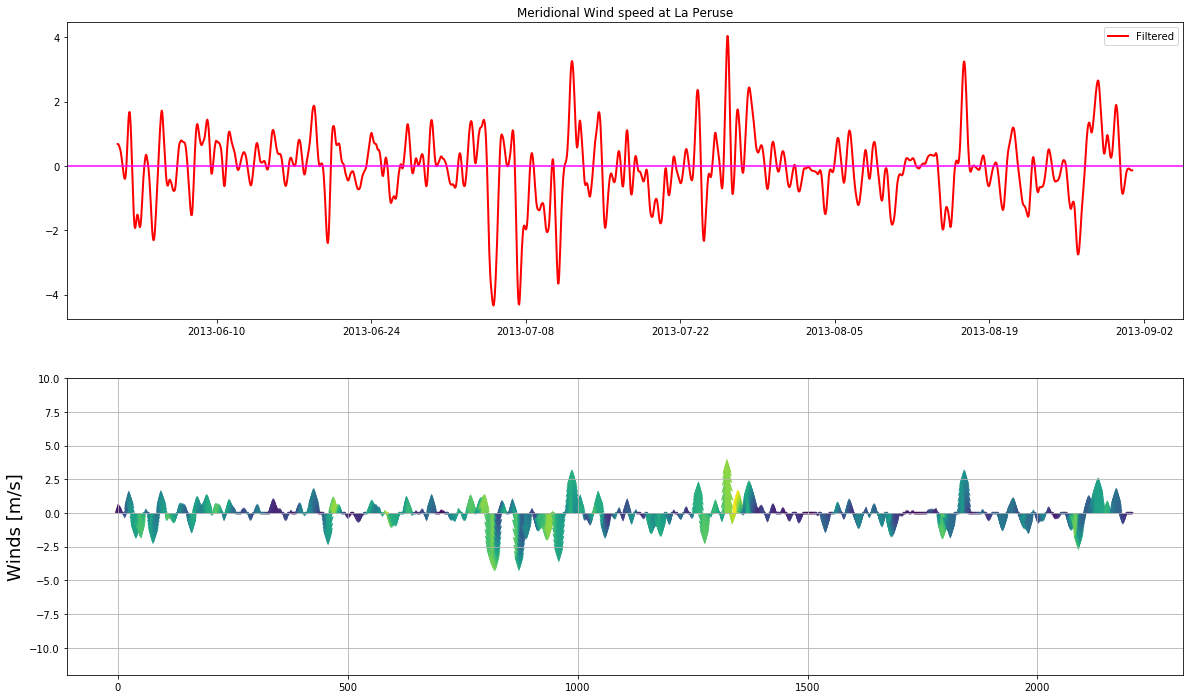

In [150]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 1
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2013[::step]
# time_axis = timenp[::step]

time_axis_quiver = np.arange(0,u_wind.shape[0],step)



s_v = v_wind[::step]   
filt_v = smooth(s_v,24,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,24,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,24,'hanning')
 
# Make plots
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,12))
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
# ax1.plot(time_axis ,vwind_esf[::step], 'r-',linewidth=2)
# ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)
ax1.plot(time_axis ,filt_v[::step], 'r-',linewidth=2)

# ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at La Peruse")
ax1.axhline(y=0, color='magenta')
# ax1.axes.get_xaxis().set_visible(True)






ax2.quiver(time_axis_quiver, 0, filt_u[::step], filt_v[::step], filt_wind[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-12,10)
ax2.grid() 



In [153]:
wind_spd = LA_PERUSE_array[start_index_2015_June:end_index_2015_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2015_June:end_index_2015_September,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2015 = LA_PERUSE_array[start_index_2015_June:end_index_2015_September,-1].astype(str)

datetime_2015 = np.empty_like(time_2015)

for i in np.arange(datetime_2015.shape[0]):
    datetime_2015[i] = datetime.strptime(time_2015[i], '%m/%d/%Y %H:%M')

datetime_2015 = datetime_2015.astype(np.datetime64)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


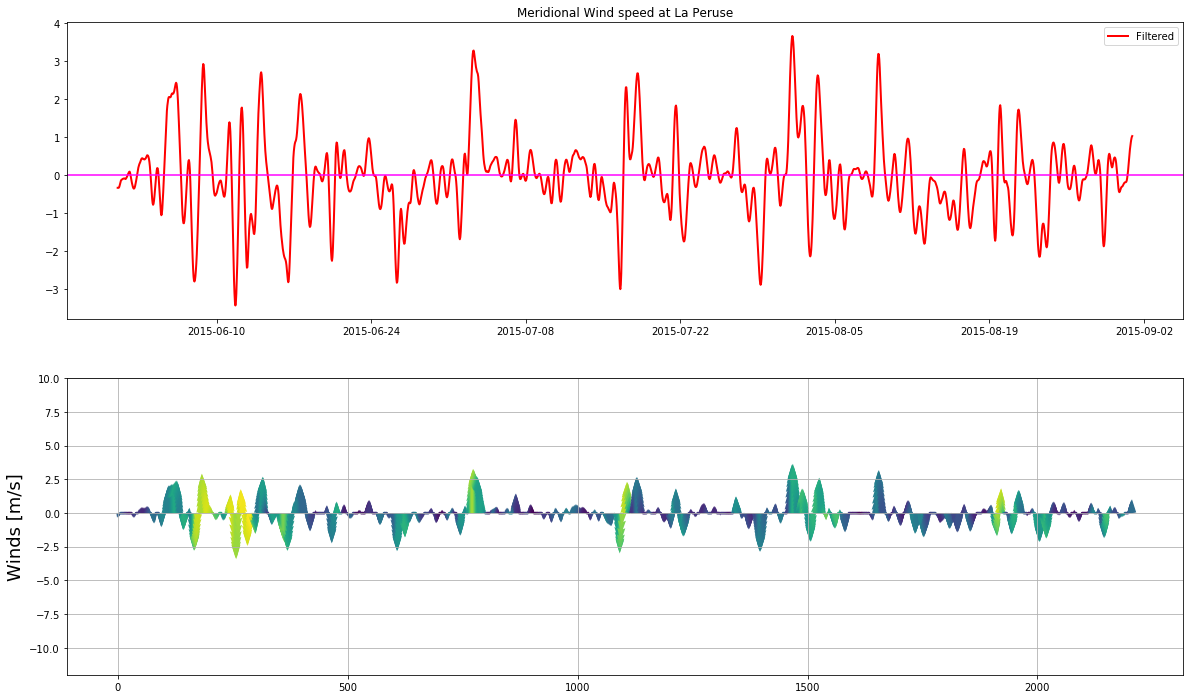

In [155]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 1
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2015[::step]
# time_axis = timenp[::step]

time_axis_quiver = np.arange(0,u_wind.shape[0],step)



s_v = v_wind[::step]   
filt_v = smooth(s_v,24,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,24,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,24,'hanning')
 
# Make plots
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,12))
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
# ax1.plot(time_axis ,vwind_esf[::step], 'r-',linewidth=2)
# ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)
ax1.plot(time_axis ,filt_v[::step], 'r-',linewidth=2)

# ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at La Peruse")
ax1.axhline(y=0, color='magenta')
# ax1.axes.get_xaxis().set_visible(True)






ax2.quiver(time_axis_quiver, 0, filt_u[::step], filt_v[::step], filt_wind[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-12,10)
ax2.grid() 



/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


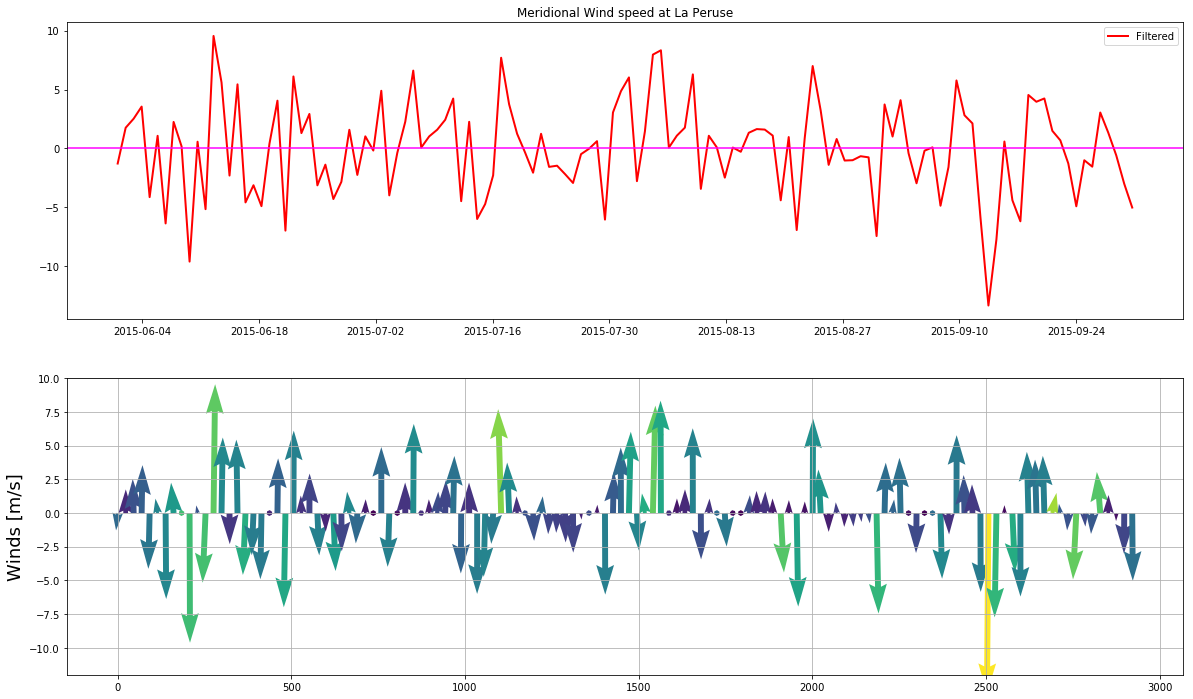

In [123]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 23
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2015[::step]
# time_axis = timenp[::step]

time_axis_quiver = np.arange(0,u_wind.shape[0],step)



# First, design the Buterworth filter
N  = 1   # Filter order
Wn = 0.5 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
vwind_esf = signal.filtfilt(B,A, v_wind[:])
uwind_esf = signal.filtfilt(B,A, u_wind[:])

u_quiver = np.array(uwind_esf[:].astype(np.float64))
v_quiver = np.array(vwind_esf[:].astype(np.float64))
 
# Make plots
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,12))
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
# ax1.plot(time_axis ,vwind_esf[::step], 'r-',linewidth=2)
ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)

# ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at La Peruse")
ax1.axhline(y=0, color='magenta')
# ax1.axes.get_xaxis().set_visible(True)






ax2.quiver(time_axis_quiver, 0, u_wind[::step], v_wind[::step], wind_spd[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-12,10)
ax2.grid() 



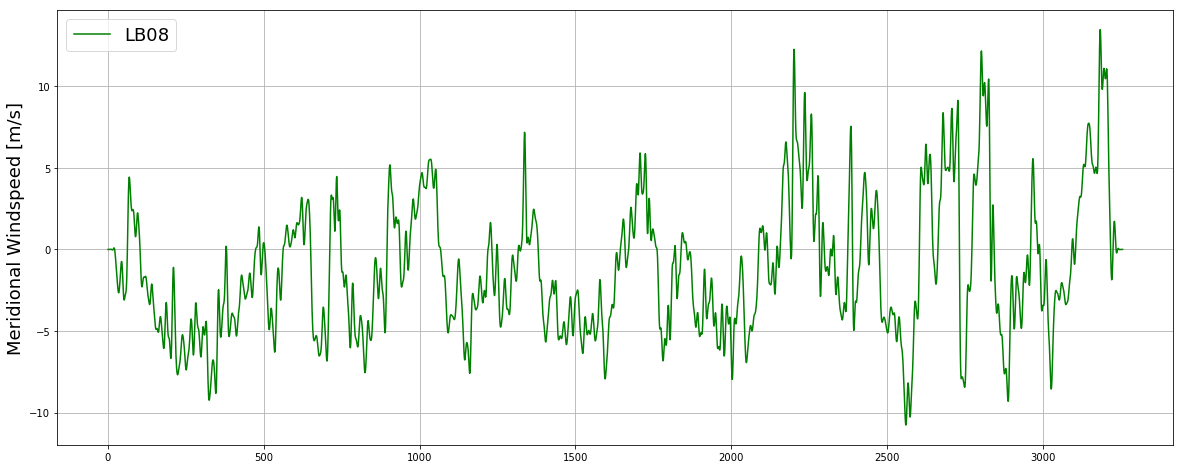

In [21]:
fc = 0.1
b = 0.08
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)

s = vwind_es[3600:6808]
new_signal = np.convolve(s, sinc_func)

fig, ax = pyplot.subplots(1, 1, figsize=(20,8))

# date_time = np.empty_like(time_es)

# for i in np.arange(1,time_es.shape[0]):
#     date_time[i]  = time_es[i].datetime
    

ax.plot(np.arange(new_signal.shape[0]), new_signal, 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax.set_ylabel('Meridional Windspeed [m/s]', fontsize =18)
ax.grid() 


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


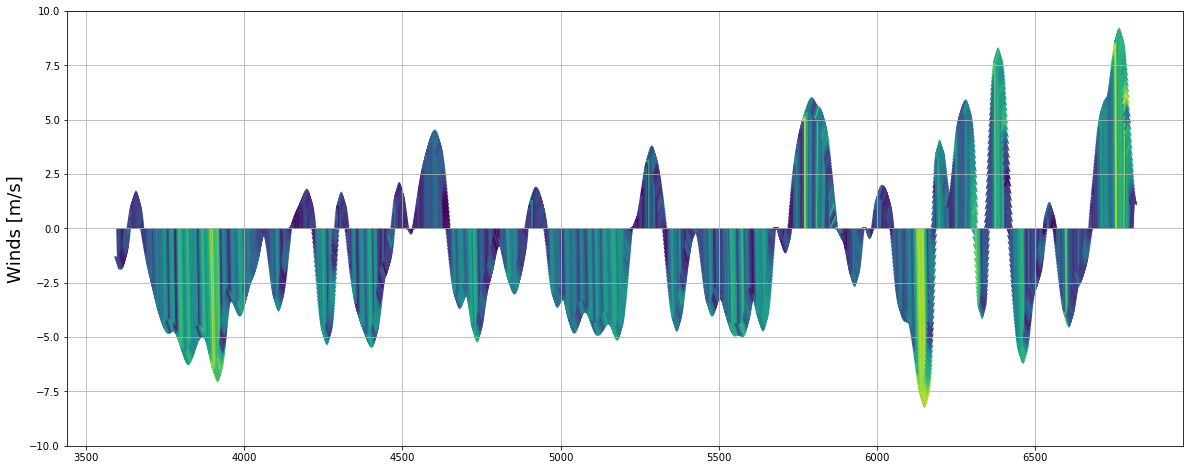

In [89]:

fig, ax = pyplot.subplots(1, 1, figsize=(20,8))


ax.quiver(np.arange(3600,6808), 0, np.array(filt_u.astype(np.float64)), np.array(filt_v.astype(np.float64)), wind_abs, angles='xy', scale_units='xy', scale=1)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax.set_ylabel('Winds [m/s]', fontsize =18)
# ax.set_xticklabels(date_time[3600:6808])
ax.set_ylim(-10,10)
ax.grid()   




# plt.figure(figsize=(10,2))
# plt.quiver((time-61), 0, u, v, uv)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


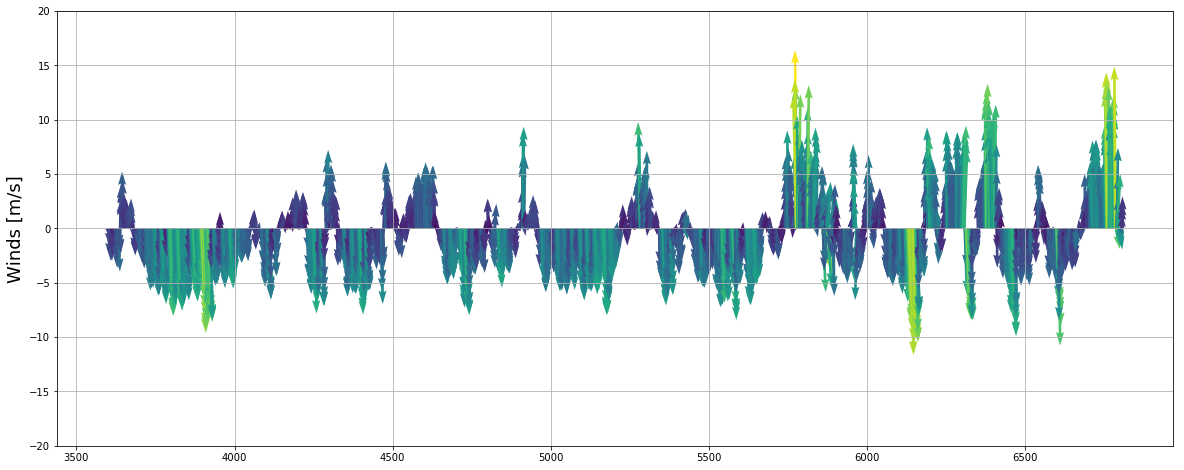

In [56]:

fig, ax = pyplot.subplots(1, 1, figsize=(20,8))


ax.quiver(np.arange(3600,6808), 0, np.array(uwind_es[3600:6808].astype(np.float64)), np.array(vwind_es[3600:6808].astype(np.float64)), wind_abs, angles='xy', scale_units='xy', scale=1)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax.set_ylabel('Winds [m/s]', fontsize =18)
# ax.set_xticklabels(date_time[3600:6808])
ax.set_ylim(-20,20)
ax.grid()   




# plt.figure(figsize=(10,2))
# plt.quiver((time-61), 0, u, v, uv)

In [47]:
np.array(vwind_es[3600:6808].astype(np.float64))

array([ 1.34638429,  1.07528865,  0.40823609, ...,  1.41424322,
        1.8352704 ,  1.44132936])

In [19]:
3600+24*92

5808

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


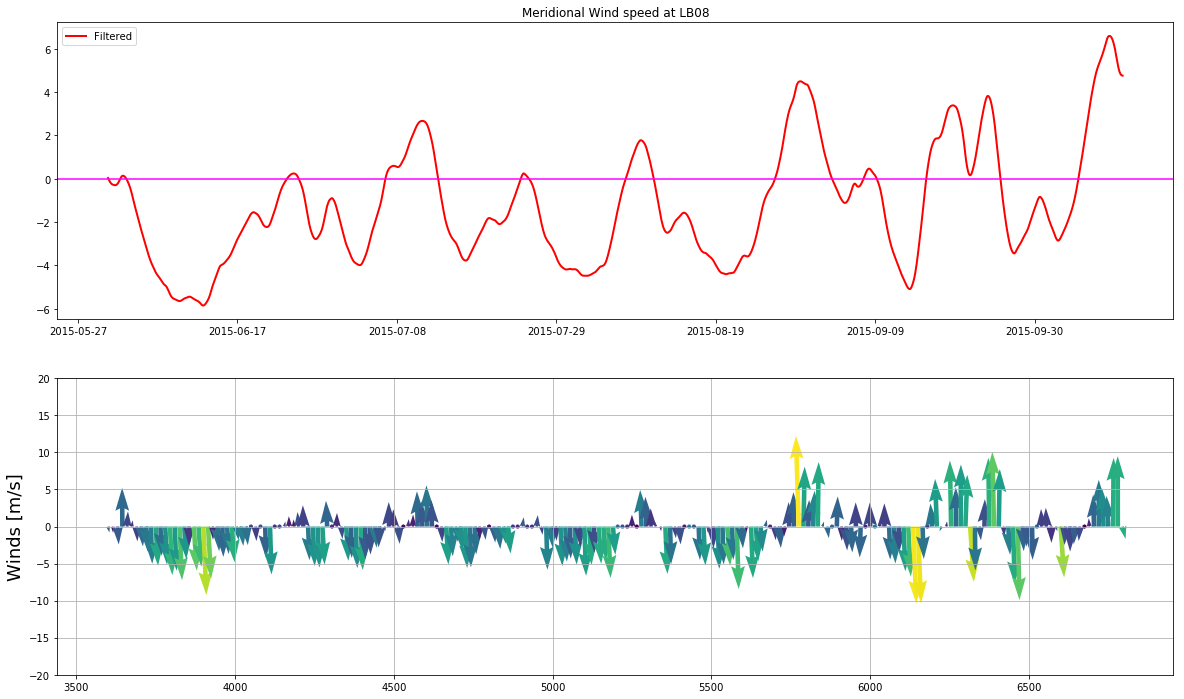

In [53]:
# First, design the Buterworth filter
N  = 1   # Filter order
Wn = 0.01 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
vwind_esf = signal.filtfilt(B,A, vwind_es[3600:6808])
 
# Make plots
fig, (ax1,ax2) = pyplot.subplots(2, 1, figsize=(20,12))
#ax1 = fig.add_subplot(211)
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
ax1.plot(date_time[3600:6808],vwind_esf, 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at LB08")
ax1.axhline(y=0, color='magenta')
ax1.axes.get_xaxis().set_visible(True)



u_quiver = np.array(uwind_es[3600:6808].astype(np.float64))
v_quiver = np.array(vwind_es[3600:6808].astype(np.float64))
step = 15
time_axis = np.arange(3600,6808,step)


ax2.quiver(time_axis, 0, u_quiver[::step], v_quiver[::step], wind_abs[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-20,20)
ax2.grid() 

In [45]:
uwind_esf.shape

(3208,)

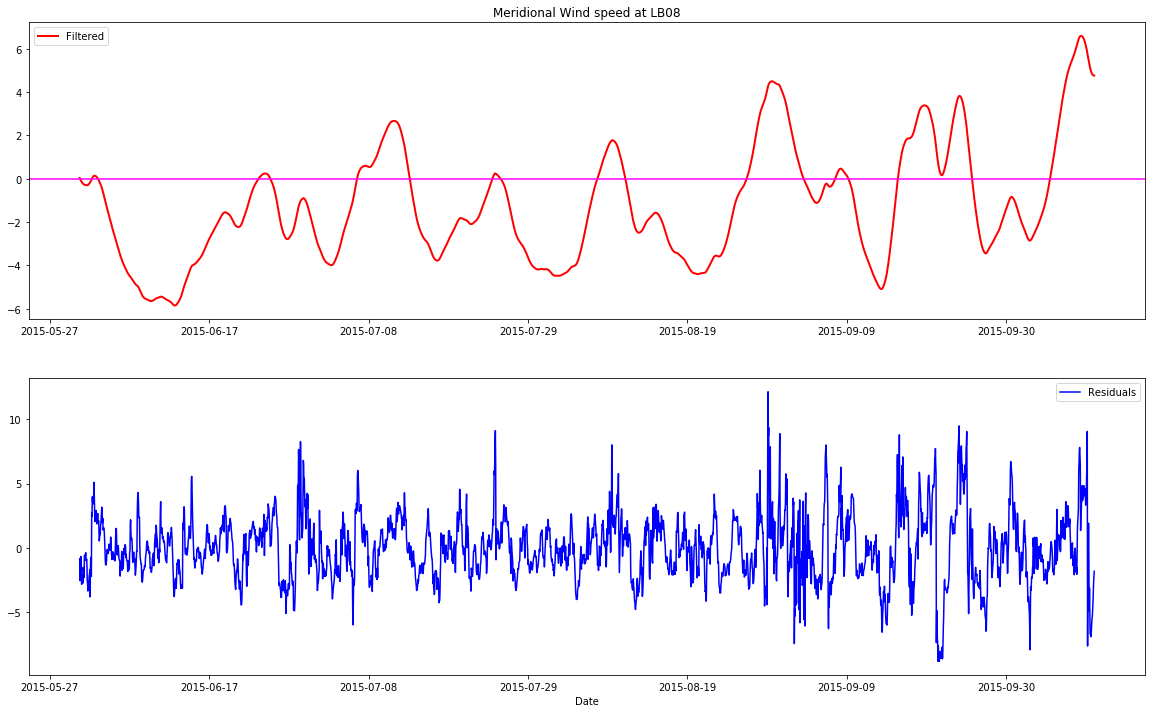

In [27]:
import scipy.signal as signal
import matplotlib.pyplot as plt
 
# First, design the Buterworth filter
N  = 1    # Filter order
Wn = 0.01 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
vwind_esf = signal.filtfilt(B,A, vwind_es[3600:6808])
 
# Make plots
fig, (ax1,ax2) = pyplot.subplots(2, 1, figsize=(20,12))
#ax1 = fig.add_subplot(211)
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
ax1.plot(date_time[3600:6808],vwind_esf, 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at LB08")
ax1.axhline(y=0, color='magenta')
ax1.axes.get_xaxis().set_visible(True)
 
#ax1 = fig.add_subplot(212)
ax2.plot(date_time[3600:6808],vwind_es[3600:6808]-vwind_esf, 'b-')
ax2.set_xlabel("Date")
ax2.legend(['Residuals'])

### Talk to BEN M about nomenclature of the GEM2.5 winds (Positive or negative and also how to do the wind barbs time series plots

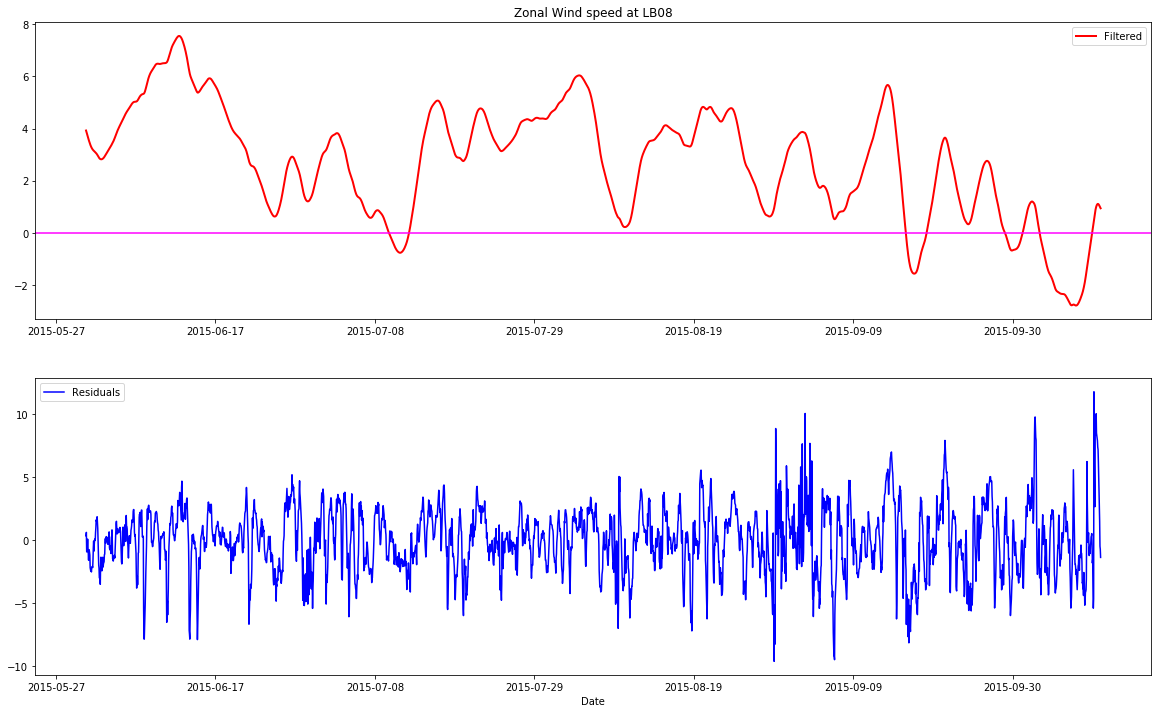

In [29]:
import scipy.signal as signal
import matplotlib.pyplot as plt
 
# First, design the Buterworth filter
N  = 1    # Filter order
Wn = 0.01 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
uwind_esf = signal.filtfilt(B,A, uwind_es[3600:6808])
 
# Make plots
fig, (ax1,ax2) = pyplot.subplots(2, 1, figsize=(20,12))
#ax1 = fig.add_subplot(211)
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
ax1.plot(date_time[3600:6808],uwind_esf, 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Zonal Wind speed at LB08")
ax1.axhline(y=0, color='magenta')
ax1.axes.get_xaxis().set_visible(True)
 
#ax1 = fig.add_subplot(212)
ax2.plot(date_time[3600:6808],uwind_es[3600:6808]-uwind_esf, 'b-')
ax2.set_xlabel("Date")
ax2.legend(['Residuals'])

In [84]:
wind_abs = np.square(uwind_es[3600:6808]) + np.square(vwind_es[3600:6808])
wind_abs = np.around(wind_abs.astype(np.double),decimals=4)
wind_abs = np.sqrt(wind_abs)
wind_abs = np.around(wind_abs.astype(np.double),decimals=4)
wind_dir_trig_to = np.arctan2(np.around(uwind_es[3600:6808].astype(np.double),decimals=4)/wind_abs, np.around(vwind_es[3600:6808].astype(np.double),decimals=4)/wind_abs) 
wind_dir_trig_to_degrees = wind_dir_trig_to * 180/np.pi

#wind_dir_trig_from_degrees = wind_dir_trig_to_degrees + 180

#wind_dir_cardinal = 90 - wind_dir_trig_from_degrees


wind_dir_cardinal = wind_dir_trig_to_degrees

In [41]:
wind_abs

array([ 2.4433,  2.36  ,  2.2306, ...,  2.3918,  2.1904,  2.3421])

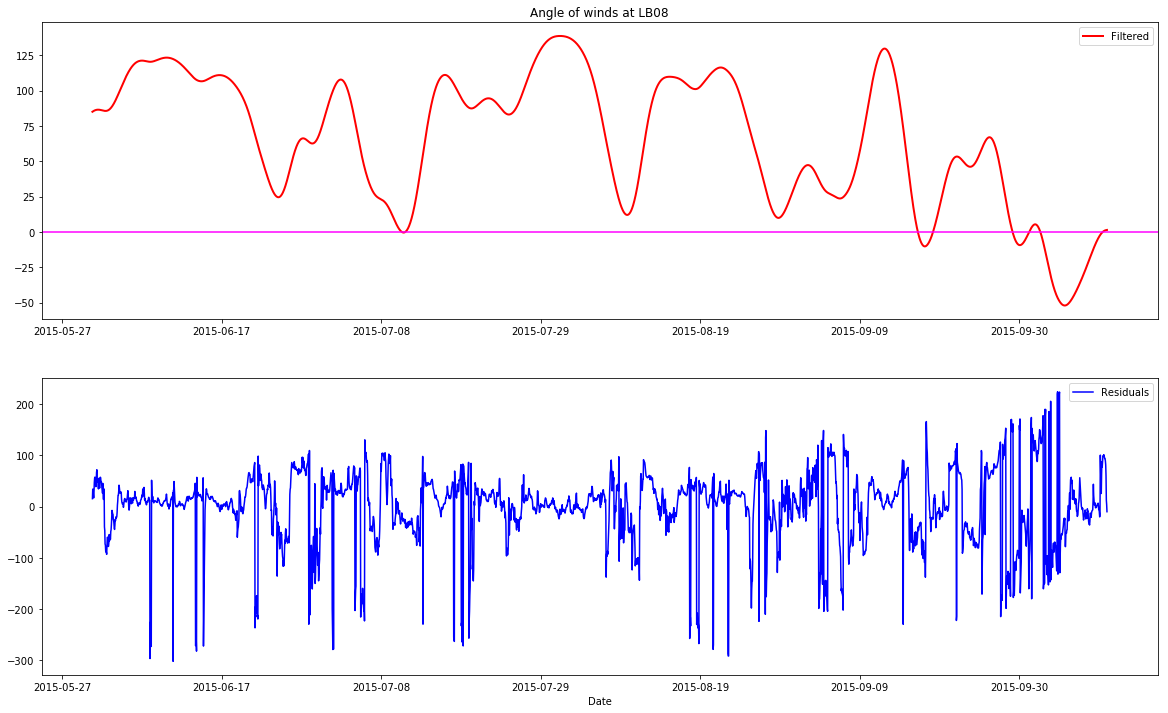

In [25]:
import scipy.signal as signal
import matplotlib.pyplot as plt
 
# First, design the Buterworth filter
N  = 2    # Filter order
Wn = 0.01 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
wind_df = signal.filtfilt(B,A, wind_dir_cardinal)
 
# Make plots
fig, (ax1,ax2) = pyplot.subplots(2, 1, figsize=(20,12))
#ax1 = fig.add_subplot(211)
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
ax1.plot(date_time[3600:6808],wind_df, 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Angle of winds at LB08")
ax1.axhline(y=0, color='magenta')
ax1.axes.get_xaxis().set_visible(True)
 
#ax1 = fig.add_subplot(212)
ax2.plot(date_time[3600:6808],wind_dir_cardinal-wind_df, 'b-')
ax2.set_xlabel("Date")
ax2.legend(['Residuals'])

In [48]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry'][:]

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']

lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]




NEP_aug = nc.Dataset('/home/ssahu/saurav/NEP36_T_S_Spice_aug.nc')


sal_aug = NEP_aug.variables['vosaline']
temp_aug = NEP_aug.variables['votemper']
spic_aug = NEP_aug.variables['spiciness']
rho_aug = NEP_aug.variables['density']


NEP_jul = nc.Dataset('/home/ssahu/saurav/NEP36_T_S_Spice_july.nc')


sal_jul  = NEP_jul.variables['vosaline']
temp_jul = NEP_jul.variables['votemper']
spic_jul = NEP_jul.variables['spiciness']
rho_jul = NEP_jul.variables['density']



In [30]:
path_to_save = '/data/ssahu/NEP36_Extracted_Months/'


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry'][:]

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']

lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

z0 = np.ma.masked_values(Z, 0)

y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

In [31]:
def tem_sal_timeseries_at_WCVI_locations(grid_scalar):#, j, i):

#     temp = grid_scalar.variables['votemper'][0,:, :, :]
#     sal = grid_scalar.variables['vosaline'][0,:, :, :]

#     wind = grid_scalar.variables['sozotaux'][0, :, :]
    wind = grid_scalar.variables['sometauy'][0, :, :]
    
    scalar_ts = namedtuple('scalar_ts', 'wind')

    return scalar_ts(wind)

In [32]:
print("Extracting June Data")    
    
    
wind_june = np.empty((30,Z.shape[0],Z.shape[1]))
# sal_june = np.empty((30,50,Z.shape[0],Z.shape[1]))


i = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201506*grid_V.nc')):

    vector_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file))
    
    wind_june[i,...] = vector_ts[0]
#     temp_june[i,...] = scalar_ts[0]
#     sal_june[i,...] = scalar_ts[1]
    i = i+1

Extracting June Data


In [54]:
nc_tools.show_variables(nc.Dataset(file))

odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'time_counter_bnds', 'votemper', 'vosaline', 'sosstsst', 'sosaline', 'sossheig', 'sowaflup', 'sowaflcd', 'sosalflx', 'sohefldo', 'soshfldo', 'somxl010', 'somixhgt', 'soicecov', 'sohefldp', 'sosafldp', 'sowafldp', 'sobowlin'])


In [4]:
file = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20150601_00374400_grid_U.nc')

In [6]:
wind = file.variables['sozotaux']

In [24]:
(j,i) = (264, 599)

In [25]:
wind_june.shape

(30, 1021, 715)

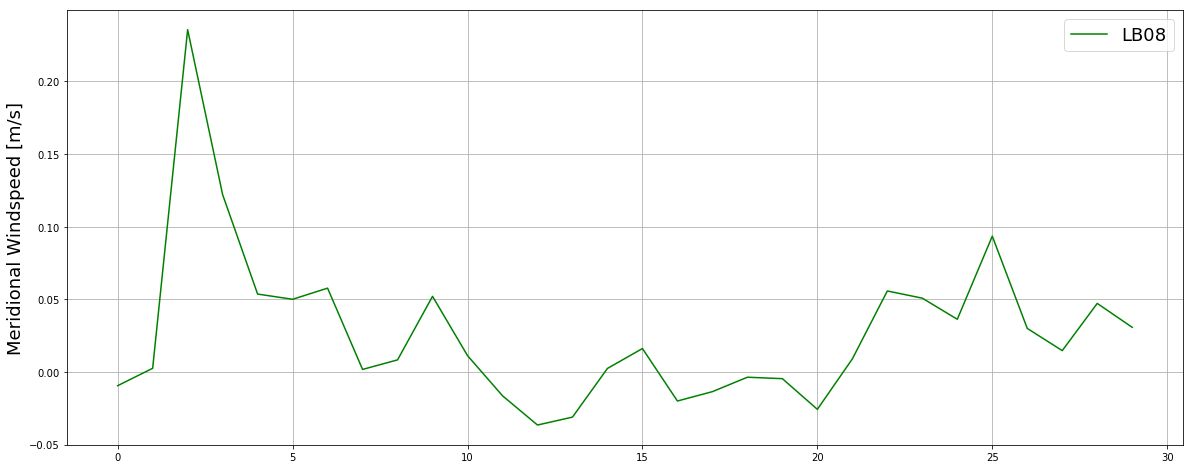

In [33]:
# from salishsea_tools import nc_tools, data_tools, tidetools, visualisations, viz_tools, stormtools, geo_tools
from collections     import OrderedDict
from matplotlib      import pyplot, animation, rcParams, patches
from dateutil        import parser
import datetime
import os
import numpy as np
import xarray


fig, ax = pyplot.subplots(1, 1, figsize=(20,8))

# date_time = np.empty_like(time_es)

# for i in np.arange(1,time_es.shape[0]):
#     date_time[i]  = time_es[i].datetime
    

ax.plot(np.arange(0,30), wind_june[:,j,i], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax.set_ylabel('Meridional Windspeed [m/s]', fontsize =18)
ax.grid()    

In [34]:
print("Extracting July Data")    
    
    
wind_july = np.empty((31,Z.shape[0],Z.shape[1]))
# sal_june = np.empty((30,50,Z.shape[0],Z.shape[1]))


i = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201507*grid_V.nc')):

    vector_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file))
    
    wind_july[i,...] = vector_ts[0]
#     temp_june[i,...] = scalar_ts[0]
#     sal_june[i,...] = scalar_ts[1]
    i = i+1

Extracting June Data


In [40]:
print("Extracting august Data")    
    
    
wind_aug = np.empty((31,Z.shape[0],Z.shape[1]))
# sal_june = np.empty((30,50,Z.shape[0],Z.shape[1]))


i = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201508*grid_V.nc')):

    vector_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file))
    
    wind_aug[i,...] = vector_ts[0]
#     temp_june[i,...] = scalar_ts[0]
#     sal_june[i,...] = scalar_ts[1]
    i = i+1

Extracting august Data


In [44]:
print("Extracting September Data")    
    
    
wind_sep = np.empty((30,Z.shape[0],Z.shape[1]))
# sal_june = np.empty((30,50,Z.shape[0],Z.shape[1]))


i = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201509*grid_V.nc')):

    vector_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file))
    
    wind_sep[i,...] = vector_ts[0]
#     temp_june[i,...] = scalar_ts[0]
#     sal_june[i,...] = scalar_ts[1]
    i = i+1

Extracting September Data


In [45]:
total_wind = np.concatenate((wind_june, wind_july, wind_aug, wind_sep), axis = 0)

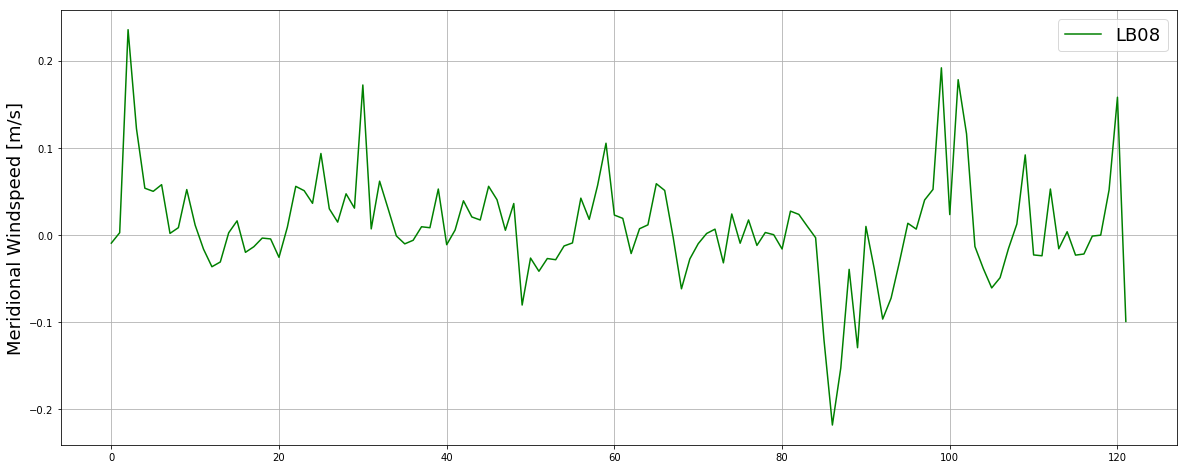

In [46]:
# from salishsea_tools import nc_tools, data_tools, tidetools, visualisations, viz_tools, stormtools, geo_tools
from collections     import OrderedDict
from matplotlib      import pyplot, animation, rcParams, patches
from dateutil        import parser
import datetime
import os
import numpy as np
import xarray


fig, ax = pyplot.subplots(1, 1, figsize=(20,8))

# date_time = np.empty_like(time_es)

# for i in np.arange(1,time_es.shape[0]):
#     date_time[i]  = time_es[i].datetime
    

ax.plot(np.arange(0,92+30), total_wind[:,j,i], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax.set_ylabel('Meridional Windspeed [m/s]', fontsize =18)
ax.grid()    

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
from datetime import datetime

import pandas as pd

In [105]:
La_Peruse_data = pd.read_table('/home/ssahu/saurav/LA_PERUSE_wavebuoy_data/c46206.csv',delim_whitespace=1,header = None, skiprows=7)

a = La_Peruse_data[0].str.split(',', expand=True)

b = La_Peruse_data[1].str.split(',', expand=True)

df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = df_La_Peruse.drop(df_La_Peruse.columns[14:], axis=1)

columns = ['STN_ID','DATE','TIME','Qflag','LATITUDE','LONGITUDE','DEPTH','VCAR','VTPK','VWH','VCMX','VTP','WDIR','WSPD','WSS','GSPD','WDIR','WSPD','WSS','GSPD','ATMS','ATMS','DRYT','SSTP']

effective = columns[:14]

df_cut.columns = effective
df_cut = df_cut.drop('Qflag',axis =1)

df_cut['Date_time']= df_cut['DATE'] + " "+ df_cut['TIME']

# df_cut = df_cut.drop('DATE', axis=1)
# df_cut = df_cut.drop('TIME', axis=1)

df_cut.tail(10)

,STN_ID,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,VCAR,VTPK,VWH,VCMX,VTP,WDIR,WSPD,Date_time
217132,C46206,06/18/2018,18:38,48.83,126.00,72.00,2.19,12.80,2.20,6.40,12.80,58.00,3.50,06/18/2018 18:38
217133,C46206,06/18/2018,19:38,48.83,126.00,72.00,2.04,12.80,2.00,3.80,12.80,64.00,3.70,06/18/2018 19:38
217134,C46206,06/19/2018,00:38,48.83,126.00,72.00,1.76,12.19,1.80,2.60,12.20,155.00,2.60,06/19/2018 00:38
217135,C46206,06/19/2018,04:38,48.83,126.00,72.00,1.66,12.19,1.70,2.70,12.20,86.00,2.60,06/19/2018 04:38
217136,C46206,06/19/2018,05:38,48.83,126.00,72.00,1.51,12.19,1.50,2.40,12.20,65.00,3.50,06/19/2018 05:38
217137,C46206,06/19/2018,06:38,48.83,126.00,72.00,1.59,11.13,1.60,2.80,11.10,64.00,4.80,06/19/2018 06:38
217138,C46206,06/19/2018,13:38,48.83,126.00,72.00,1.51,11.64,1.40,7.10,11.60,51.00,4.60,06/19/2018 13:38
217139,C46206,06/19/2018,17:38,48.83,126.00,72.00,1.50,11.13,1.30,7.00,11.10,72.00,4.20,06/19/2018 17:38
217140,C46206,06/19/2018,18:38,48.83,126.00,72.00,1.45,15.06,1.40,5.20,15.10,84.00,3.40,06/19/2018 18:38
217141,C46206,06/19/2018,21:38,48.83,126.00,72.00,1.47,10.67,1.50,2.10,10.70,87.00,2.50,06/19/2018 21:38


In [111]:
LA_PERUSE_array = df_cut.as_matrix()

start_index_2015_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2015')))[0,0]

end_index_2015_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '09/30/2015')))[-1,0]

start_index_2013_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2013')))[0,0]
LA_PERUSE_array = df_cut.as_matrix()

start_index_2015_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2015')))[0,0]

end_index_2015_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '09/30/2015')))[-1,0]

start_index_2013_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2013')))[0,0]

end_index_2013_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '09/30/2013')))[-1,0]
end_index_2013_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '09/30/2013')))[-1,0]

In [59]:
wind_spd = LA_PERUSE_array[start_index_2015_June:end_index_2015_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2015_June:end_index_2015_September,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2015 = LA_PERUSE_array[start_index_2015_June:end_index_2015_September,-1].astype(str)

datetime_2015 = np.empty_like(time_2015)

for i in np.arange(datetime_2015.shape[0]):
    datetime_2015[i] = datetime.strptime(time[i], '%m/%d/%Y %H:%M')

In [60]:
datetime_2015 = datetime_2015.astype(np.datetime64)

In [61]:
datetime_2015

array(['2015-06-01T00:38', '2015-06-01T01:38', '2015-06-01T02:38', ...,
       '2015-09-30T20:38', '2015-09-30T21:38', '2015-09-30T22:38'], dtype='datetime64[m]')

In [62]:
timenp = np.array(datetime_2015, dtype='datetime64[us]')

In [63]:
timenp

array(['2015-06-01T00:38:00.000000', '2015-06-01T01:38:00.000000',
       '2015-06-01T02:38:00.000000', ..., '2015-09-30T20:38:00.000000',
       '2015-09-30T21:38:00.000000', '2015-09-30T22:38:00.000000'], dtype='datetime64[us]')

In [64]:
timenp[0:25]

array(['2015-06-01T00:38:00.000000', '2015-06-01T01:38:00.000000',
       '2015-06-01T02:38:00.000000', '2015-06-01T03:38:00.000000',
       '2015-06-01T04:38:00.000000', '2015-06-01T05:38:00.000000',
       '2015-06-01T06:38:00.000000', '2015-06-01T07:38:00.000000',
       '2015-06-01T08:38:00.000000', '2015-06-01T09:38:00.000000',
       '2015-06-01T10:38:00.000000', '2015-06-01T11:38:00.000000',
       '2015-06-01T12:38:00.000000', '2015-06-01T13:38:00.000000',
       '2015-06-01T14:38:00.000000', '2015-06-01T15:38:00.000000',
       '2015-06-01T16:38:00.000000', '2015-06-01T17:38:00.000000',
       '2015-06-01T18:38:00.000000', '2015-06-01T19:38:00.000000',
       '2015-06-01T20:38:00.000000', '2015-06-01T21:38:00.000000',
       '2015-06-01T22:38:00.000000', '2015-06-01T23:38:00.000000',
       '2015-06-02T00:38:00.000000'], dtype='datetime64[us]')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


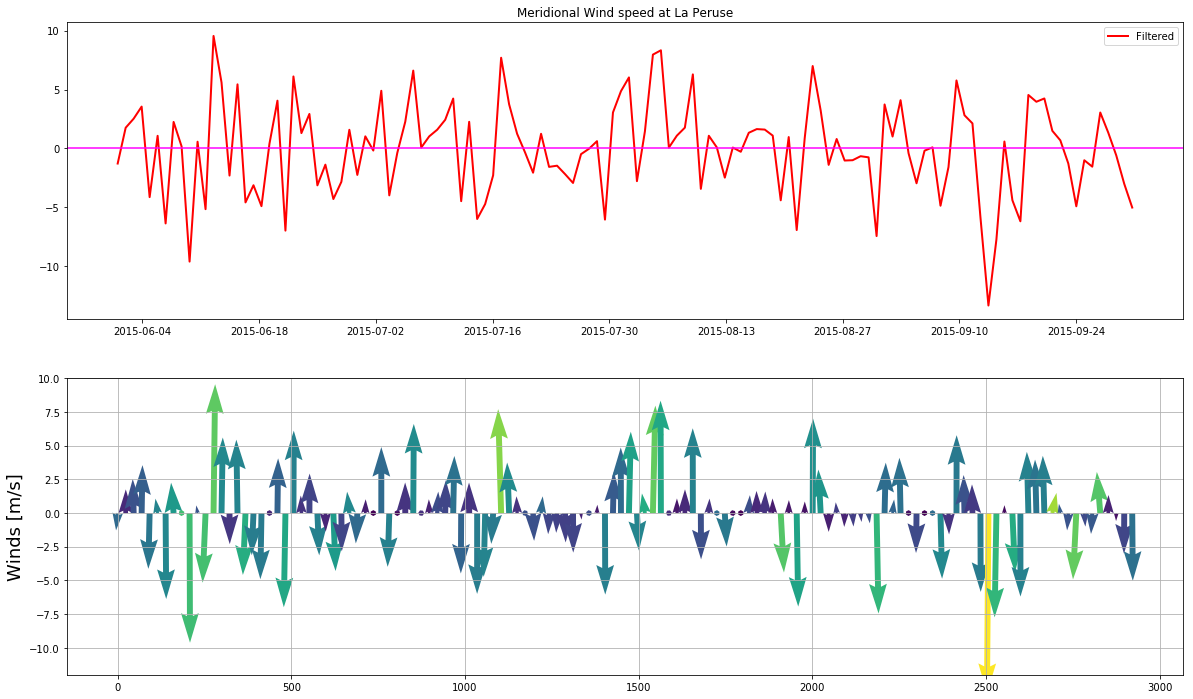

In [65]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 23
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2015[::step]
# time_axis = timenp[::step]

time_axis_quiver = np.arange(0,u_wind.shape[0],step)



# First, design the Buterworth filter
N  = 1   # Filter order
Wn = 0.5 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
vwind_esf = signal.filtfilt(B,A, v_wind[:])
uwind_esf = signal.filtfilt(B,A, u_wind[:])

u_quiver = np.array(uwind_esf[:].astype(np.float64))
v_quiver = np.array(vwind_esf[:].astype(np.float64))
 
# Make plots
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,12))
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
# ax1.plot(time_axis ,vwind_esf[::step], 'r-',linewidth=2)
ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)

# ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at La Peruse")
ax1.axhline(y=0, color='magenta')
# ax1.axes.get_xaxis().set_visible(True)






ax2.quiver(time_axis_quiver, 0, u_wind[::step], v_wind[::step], wind_spd[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-12,10)
ax2.grid() 



In [75]:
filt = smooth(s,72,'hanning')



In [79]:
s.shape

(3208,)

In [78]:
filt.shape

(3208,)

In [67]:
filt = smooth(v_wind[:],72,'hanning')

filt_1 = filt[::step]

filt_2 = filt_1[3:]

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


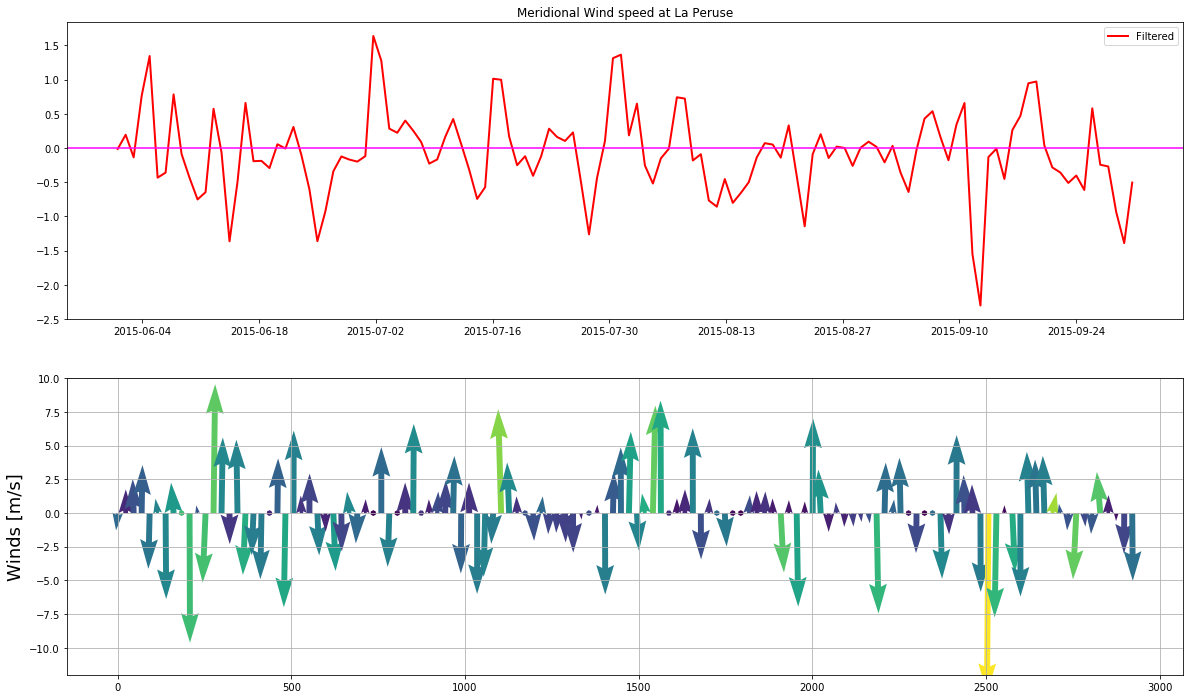

In [68]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 23
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2015[::step]
# time_axis = timenp[::step]

time_axis_quiver = np.arange(0,u_wind.shape[0],step)



# First, design the Buterworth filter
N  = 1   # Filter order
Wn = 0.5 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
vwind_esf = signal.filtfilt(B,A, v_wind[:])
uwind_esf = signal.filtfilt(B,A, u_wind[:])

u_quiver = np.array(uwind_esf[:].astype(np.float64))
v_quiver = np.array(vwind_esf[:].astype(np.float64))
 
# Make plots
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,12))
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
# ax1.plot(time_axis ,vwind_esf[::step], 'r-',linewidth=2)
ax1.plot(time_axis ,filt_2, 'r-',linewidth=2)

# ax1.plot(time_axis ,v_wind[::step], 'r-',linewidth=2)
# ax1.set_ylim([-1.5, 2.5])
#ax1.legend(['Original','Filtered'])
ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at La Peruse")
ax1.axhline(y=0, color='magenta')
# ax1.axes.get_xaxis().set_visible(True)






ax2.quiver(time_axis_quiver, 0, u_wind[::step], v_wind[::step], wind_spd[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-12,10)
ax2.grid() 



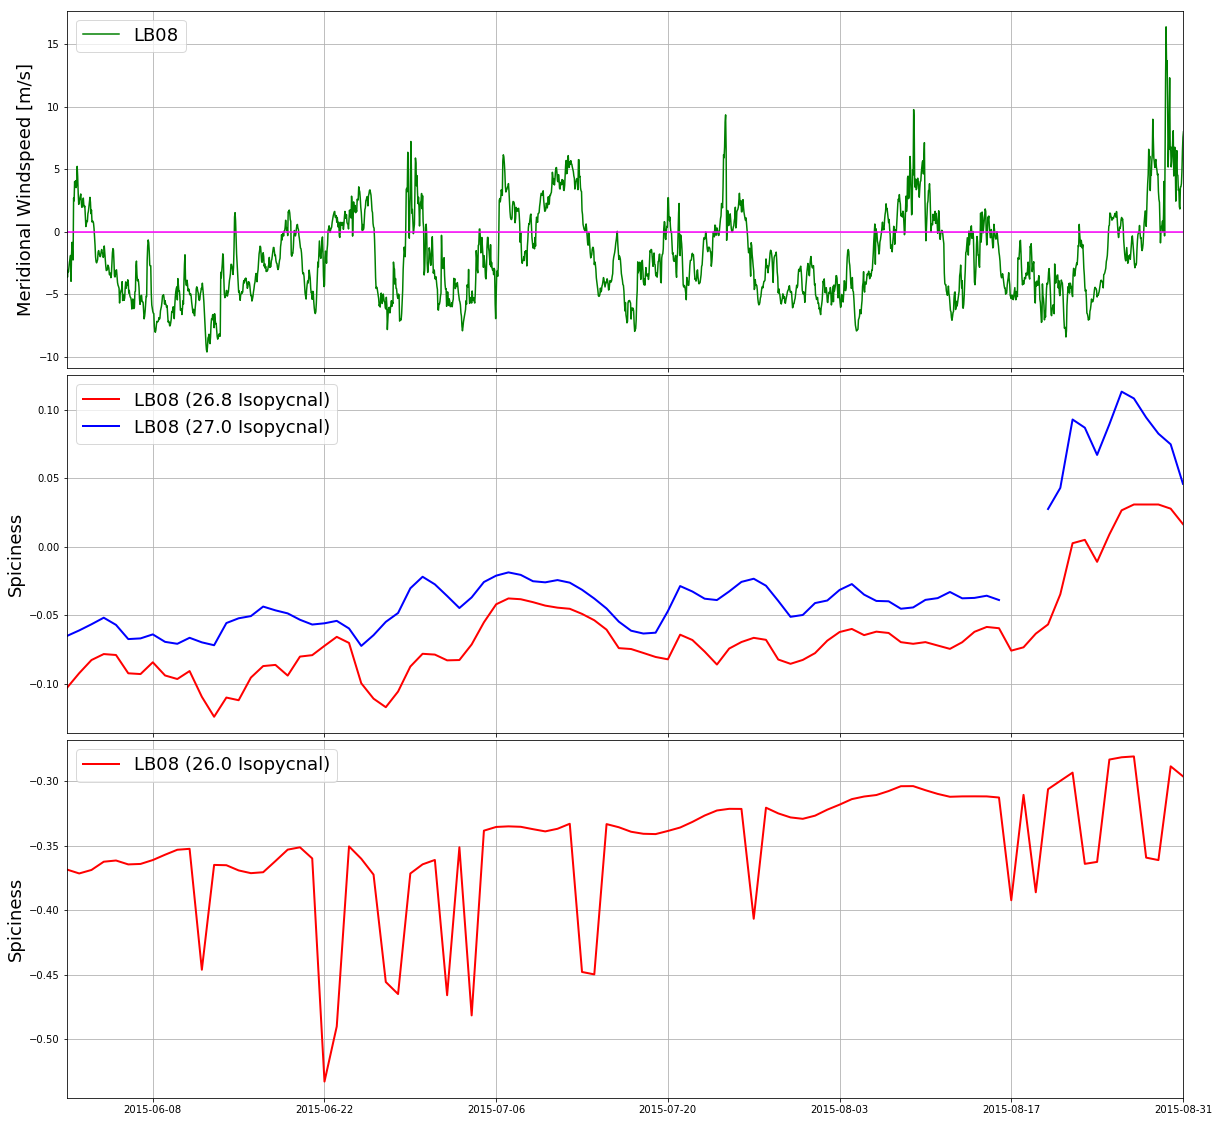

In [129]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 23
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2015[::step]
# time_axis = timenp[::step]

time_axis_quiver = np.arange(0,u_wind.shape[0],step)



# First, design the Buterworth filter
N  = 1   # Filter order
Wn = 0.5 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
vwind_esf = signal.filtfilt(B,A, v_wind[:])
uwind_esf = signal.filtfilt(B,A, u_wind[:])

u_quiver = np.array(uwind_esf[:].astype(np.float64))
v_quiver = np.array(vwind_esf[:].astype(np.float64))
 
# Make plots
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(20,20), sharex= True)
# ax1.plot(date_time[3600:6808],vwind_es[3600:6808], 'b-')
# ax1.plot(time_axis ,vwind_esf[::step], 'r-',linewidth=2)
ax1.plot(date_time[3625:5832], vwind_es[3625:5832], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax1.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax1.set_ylabel('Meridional Windspeed [m/s]', fontsize =18)
ax1.axhline(y=0, color='magenta')
ax1.set_xlim(date_time[3625], date_time[5832])
ax1.grid()
# ax1.axes.get_xaxis().set_visible(True)





ax2.plot(mydates , spic_3_months_LB08_26, 'r-',linewidth=2, label = 'LB08 (26.8 Isopycnal)')
ax2.plot(mydates , spic_3_months_LB08_27, 'b-',linewidth=2, label = 'LB08 (27.0 Isopycnal)')
# ax2.quiver(time_axis_quiver, 0, u_wind[::step], v_wind[::step], wind_spd[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Spiciness', fontsize =18)
ax2.set_xlim(mydates[0],mydates[-1])
#ax.set_xticklabels(date_time[3600:6808])
# ax2.set_ylim(-12,10)
ax2.grid() 

ax3.plot(mydates , spic_3_months_LB08_0, 'r-',linewidth=2, label = 'LB08 (26.0 Isopycnal)')
# ax2.plot(mydates , spic_3_months_LB08_27, 'b-',linewidth=2, label = 'LB08 (27.0 Isopycnal)')
# ax2.quiver(time_axis_quiver, 0, u_wind[::step], v_wind[::step], wind_spd[::step], angles='xy', scale_units='xy', scale=1)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')
# ax.plot(date_time[1:], vwind_bs[1:], 'r-', label = 'Barkley Sound')
# ax.plot(date_time[1:], vwind_cw[1:], 'g-', label = 'Washington Coast')
legend = ax3.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax3.set_ylabel('Spiciness', fontsize =18)
ax3.set_xlim(mydates[0],mydates[-1])
#ax.set_xticklabels(date_time[3600:6808])
# ax2.set_ylim(-12,10)
ax3.grid() 

plt.subplots_adjust(hspace=.02)




### Draw a vertical section at LB08 cutting at a constant y index

In [123]:
date_time[5832]

datetime.datetime(2015, 8, 31, 23, 0, tzinfo=tzutc())

In [105]:
date_time[3625]

datetime.datetime(2015, 6, 1, 0, 0, tzinfo=tzutc())

In [47]:
spic_3_months_LB08

array([-0.06520196, -0.06116589, -0.05667581, -0.05187742, -0.05711899,
       -0.06749399, -0.06699272, -0.06406055, -0.06951844, -0.07094076,
       -0.06654962, -0.06988055, -0.07198513, -0.0557846 , -0.0523008 ,
       -0.05069733, -0.04373977, -0.0464999 , -0.04872366, -0.0533741 ,
       -0.05686188, -0.0559625 , -0.0541811 , -0.05973557, -0.07247937,
       -0.0646228 , -0.05490448, -0.04843602, -0.03038492, -0.02195702,
       -0.02749917, -0.03599685, -0.04480277, -0.03702544, -0.02579564,
       -0.02113396, -0.01875808, -0.02058119, -0.02521674, -0.02603213,
       -0.02437737, -0.02626474, -0.031472  , -0.0378817 , -0.04515059,
       -0.05475524, -0.06137498, -0.06343754, -0.06282642, -0.04708882,
       -0.02875311, -0.03273508, -0.03798972, -0.03897827, -0.0326874 ,
       -0.02569623, -0.02340107, -0.02849214, -0.0395918 , -0.05122806,
       -0.04987673, -0.04118764, -0.03930661, -0.03160733, -0.02730494,
       -0.03501521, -0.03962323, -0.03987796, -0.04532751, -0.04

In [28]:
short_spic_iso_jun.shape

(30, 20, 170, 170)

In [31]:
short_iso_t[10]

27.0

In [123]:
filt_2.shape

(128,)

In [ ]:
t=linspace(-4,4,100)
x=sin(t)
xn=x+randn(len(t))*0.1
y=smooth(x)

ws=31

subplot(211)
plot(ones(ws))

windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

hold(True)
for w in windows[1:]:
    eval('plot('+w+'(ws) )')

axis([0,30,0,1.1])

legend(windows)
title("The smoothing windows")
subplot(212)
plot(x)
plot(xn)
for w in windows:
    plot(smooth(xn,10,w))
l=['original signal', 'signal with noise']
l.extend(windows)

legend(l)
title("Smoothing a noisy signal")
show()

In [68]:
np.mean(v_wind[::step])

-0.0704543580770466

In [117]:
wind_spd[::step].shape

(196,)

In [119]:
time_axis.shape

(214,)

In [68]:
LA_PERUSE_array[0,13]

'11/23/1988 06:34'

In [67]:
np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2015'))

array([[193863, 193864, 193865, 193866, 193867, 193868, 193869, 193870,
        193871, 193872, 193873, 193874, 193875, 193876, 193877, 193878,
        193879, 193880, 193881, 193882, 193883, 193884, 193885, 193886]])

In [61]:
start_index_2015_June = b[0,0] = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2015')))[0,0]

end_index_2015_September = b[0,0] = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '09/30/2015')))[-1,0]

In [62]:
start_index_2015_June

193863

In [63]:
end_index_2015_September

196790

In [52]:
b.shape

(24, 1)

In [56]:
start_index_2015_June = b[0,0]

In [57]:
start_index_2015_June

193863

In [37]:
LA_PERUSE_array[:,1]

array(['11/23/1988', '11/23/1988', '11/23/1988', ..., '06/19/2018',
       '06/19/2018', '06/19/2018'], dtype=object)

In [8]:
LA_PERUSE_array[:,1]

array(['11/23/1988', '11/23/1988', '11/23/1988', ..., '06/19/2018',
       '06/19/2018', '06/19/2018'], dtype=object)

In [ ]:
# grid = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc',mask_and_scale=False)
masked = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')
results = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m01d01.nc')
# Jan1_data = xr.open_dataset('/results/SalishSea/nowcast-green/01jan17/SalishSea_1h_20170101_20170101_grid_T.nc')